In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'..')
from timeit import default_timer as timer
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import src.cfg as cfg
import src.data as data
import src.models as models
import src.processing as processing
import src.filters as fltr

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams["date.autoformatter.year"] = "%Y"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.style.use('seaborn-whitegrid')


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import backend as K

/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
def coords_to_point(coords):
    from src.utils import MyNetCDF
    ncdf = MyNetCDF(path='../data/meta/land-exapmle-int.nc')
    return list(ncdf.coords_to_index(coords)[0].data)

def plotting(pred, y_test, model_data, years_test, fltrd=None,title=None):
    
    # plotting settings

    fig, ax = plt.subplots()
    plt.gca().xaxis.grid(True, linestyle='--')
    
    dates = pd.date_range('01/01/{}'.format(years_test[0]), '31/12/{}'.format(years_test[-1])).to_pydatetime()

    ax.plot(dates, pred, label='Predictions', alpha=0.4)
    ax.plot(dates, y_test, label='Measurements',linewidth=3)
    ax.plot(dates, model_data, label = 'NEMO', alpha=0.8)
    if fltrd is not None:
        ax.plot(dates, fltrd, label = 'Filtered')
    
    ax.axhline(y=0, color='grey', linestyle='-')
    fig.legend()
    fig.autofmt_xdate()

    if title is not None: plt.title(title)
#     plt.show()
    
    return plt

In [3]:
def plotting(title=None, years_test=None, **kwargs):
    
    # plotting settings

    fig, ax = plt.subplots()
    plt.gca().xaxis.grid(True, linestyle='--')
    
    dates = pd.date_range('01/01/{}'.format(years_test[0]), '31/12/{}'.format(years_test[-1])).to_pydatetime()
    
    for key, value in kwargs.items():
        if key=='TOPAZ':
            ax.plot(dates, value, label=key, linewidth=3)
        else:
            ax.plot(dates, value, label=key, alpha=0.8)
    
    ax.axhline(y=0, color='grey', linestyle='-')
    ax.legend()
    fig.autofmt_xdate()
    
    return plt

In [4]:
parameters = dict(years_train=list(range(2010, 2015)),
                  years_test=[2015],
                  X_vars=['ice_conc','icethic_cea', 'tair'],
                  y_var='hice',
                  bounds=[0, 400, 0, 400],
                  step=[20, 20],
                  dx=5,
                  dy=5,
                  dt=5,
                  n_neurons=20,
                  epochs=70,
                  batch_size=30,
                  loss='mae'
                  )

#filters = dict(partial_pca=10)

y_arr_train, X_arr_train = data.load_features(parameters['y_var'],
                                              parameters['X_vars'],
                                              parameters['years_train'])

y_arr_test, X_arr_test = data.load_features(parameters['y_var'],
                                            parameters['X_vars'],
                                            parameters['years_test'])
mask = np.load(cfg.mask_path)

ft = fltr.FeatureTable(dx=parameters['dx'],
                       dy=parameters['dy'],
                       dt=parameters['dt'])

In [5]:
n_point=1
points = [[78,84],[80,-5],[73.6,162],[85,-180]]
point = coords_to_point(points[n_point])

model_data = data.load_variable_years('icethic_cea', parameters['years_test'], point)
y_true =data.load_variable_years(parameters['y_var'], parameters['years_test'], point)

In [6]:
y_train = y_arr_train[:, point[0], point[1]]
y_test = y_arr_test[:, point[0], point[1]]
X_train = ft.gen_matrix(data=X_arr_train, x=point[0], y=point[1], filters=None)
X_test = ft.gen_matrix(data=X_arr_test, x=point[0], y=point[1], filters=None)

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = scaler.transform(X_train)
y_train, X_train = models.clean_data(X=X_train_scaled, y=y_train)
#X_train = models.reshape2d(X_train_scaled)

In [13]:
X_test_scaled.shape

(365, 3993)

In [ ]:
model = Sequential()

model.add(LSTM(parameters['n_neurons'],
                    input_shape=(X_train.shape[1], X_train.shape[2]),
                    return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(20))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss=parameters['loss'], optimizer='adam')
print(self.model.summary())
history = model.fit(X_train, y_train,
                              epochs=parameters['epochs'],
                              batch_size=parameters['batch_size'],
                              verbose=0, shuffle=False)

In [27]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def rmse(a1, a2):
    return (np.nanmean(np.power(a1-a2, 2)))

reg_params = dict(n_neurons=32,
                  epochs=200,
                  batch_size=40,
                  loss='mean_squared_error')

/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Time: LSTM 223.93712900000173s   LASSO: 0.006803000000218162s
RMSE: LSTM 0.34876266174352305   LASSO: 0.3023620356877111


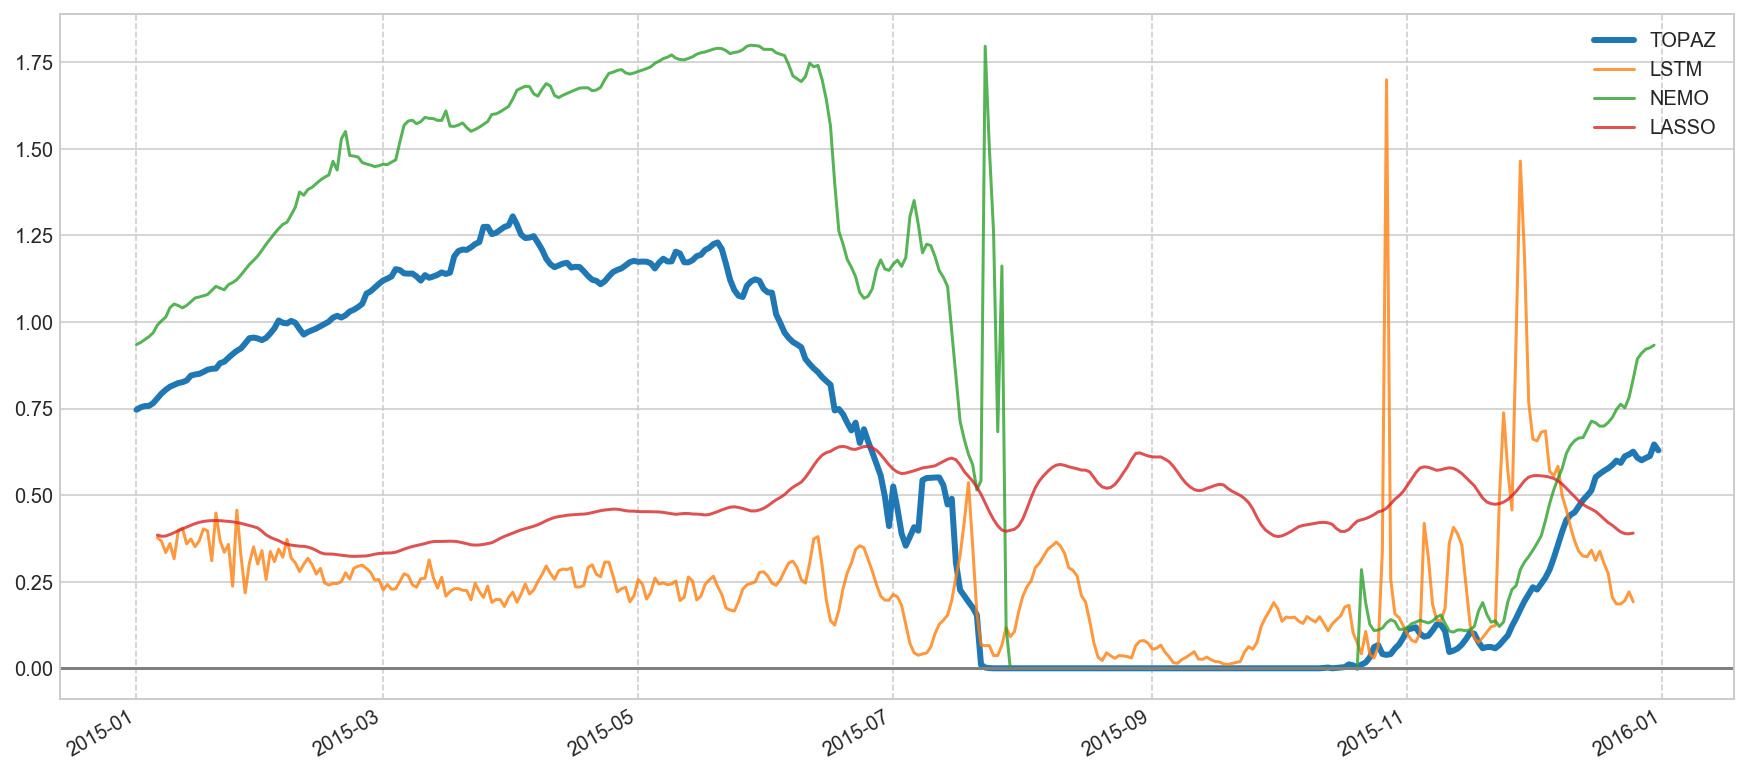

/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Time: LSTM 211.14435799999774s   LASSO: 0.010911000001215143s
RMSE: LSTM 0.4740886319274889   LASSO: 0.4186178035844593


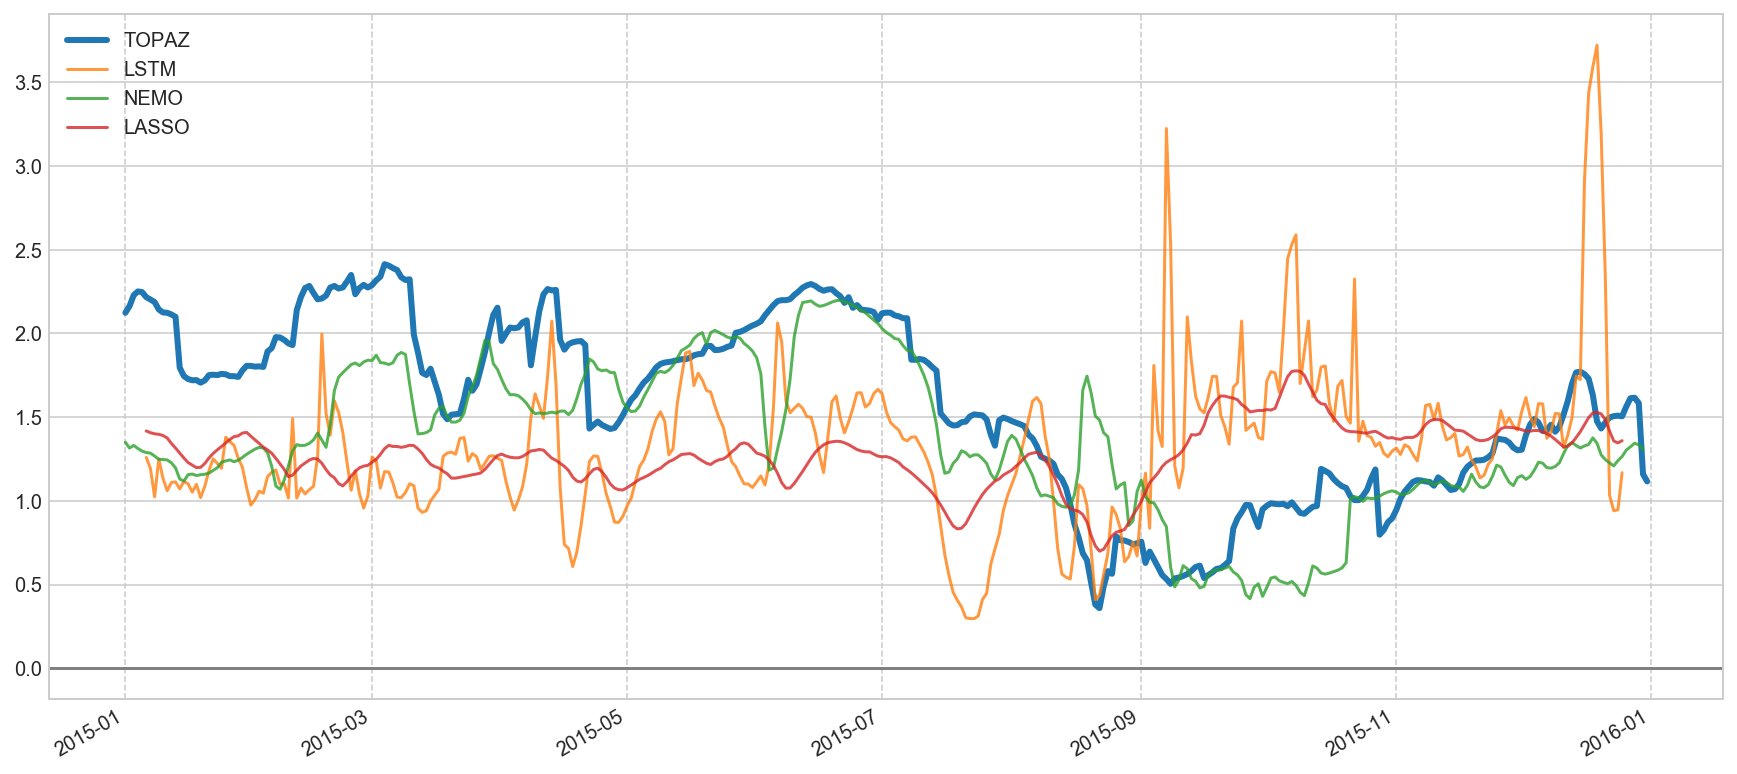

/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Time: LSTM 217.66803900000014s   LASSO: 0.007964000000356464s
RMSE: LSTM 0.8255612429136713   LASSO: 0.510281295665452


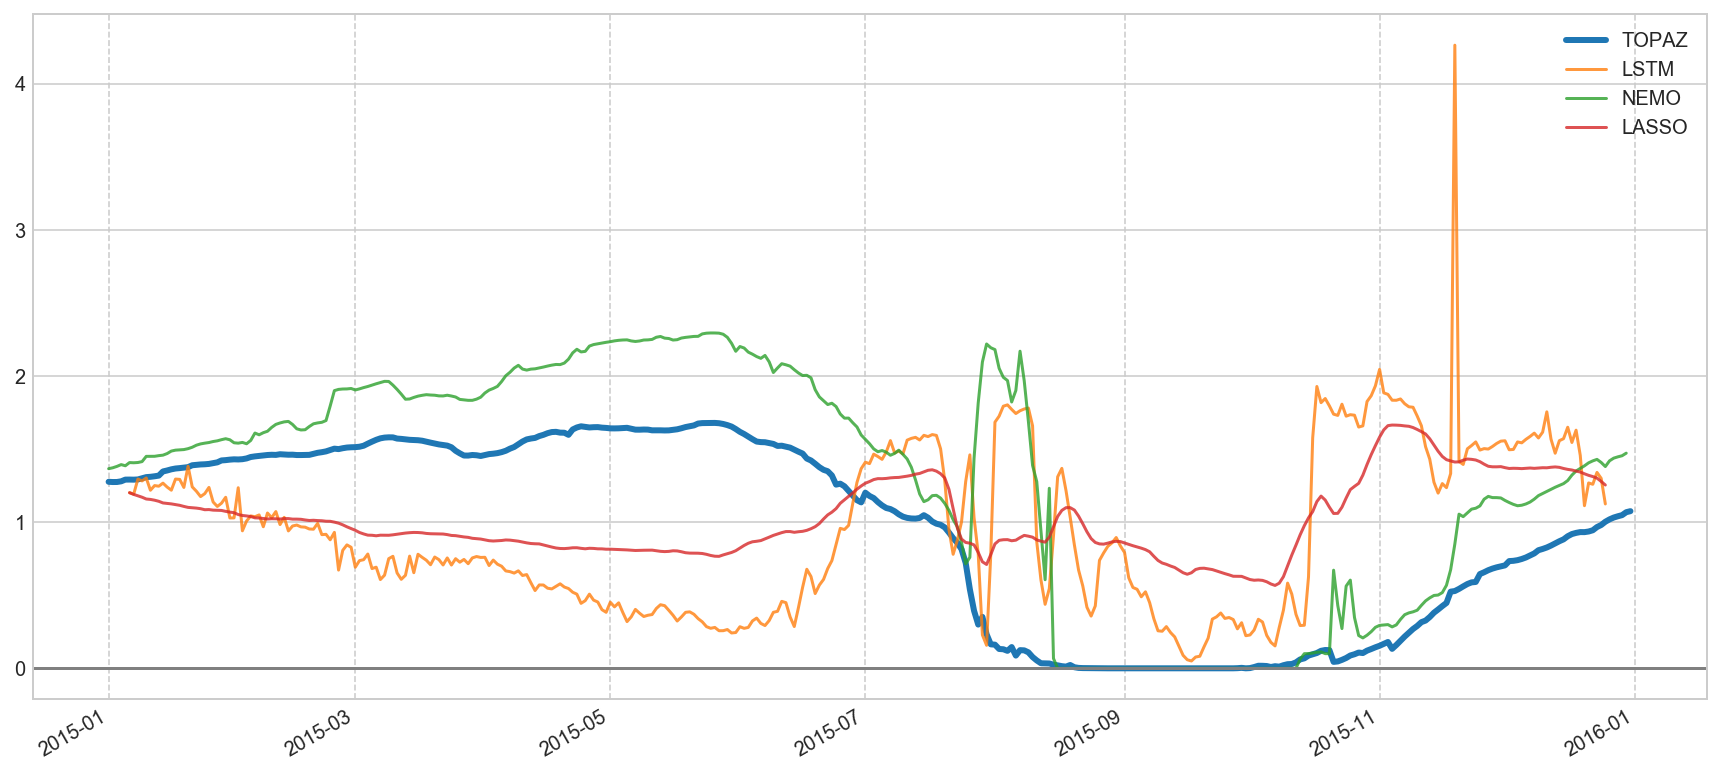

/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Time: LSTM 204.52328000000125s   LASSO: 0.009754000002430985s
RMSE: LSTM 0.16788540620121084   LASSO: 0.10374997639451497


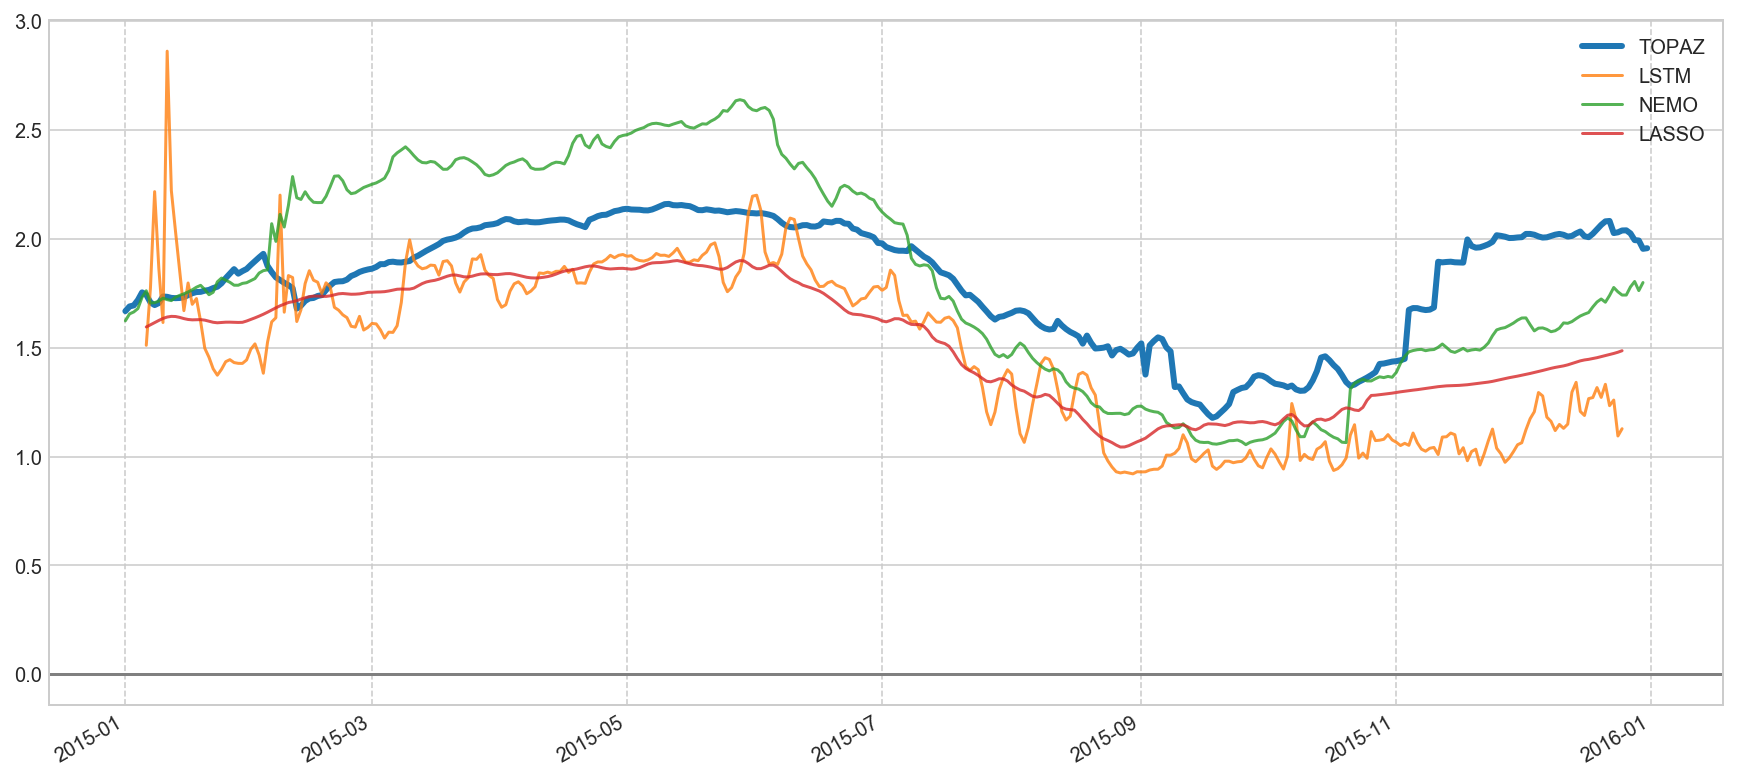

In [91]:
points = [[78,84],[80,-5],[73.6,162],[85,-180]]
reg_params = dict(n_neurons=32,
                  epochs=500,
                  batch_size=30,
                  loss='mean_squared_error')

point = coords_to_point(points[1])

model_data = data.load_variable_years('icethic_cea', parameters['years_test'], point)
y_true =data.load_variable_years(parameters['y_var'], parameters['years_test'], point)

y_train = y_arr_train[:, point[0], point[1]]
y_test = y_arr_test[:, point[0], point[1]]
X_train = ft.gen_matrix(data=X_arr_train, x=point[0], y=point[1], filters=None)
X_test = ft.gen_matrix(data=X_arr_test, x=point[0], y=point[1], filters=None)

scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = scaler.transform(X_train)

t1_lstm=time.clock()
lstm = models.MyLSTM()
lstm.fit(X_train_scaled, y_train, parameters=reg_params)
pred_lstm = lstm.predict(X_test_scaled)
pred_fltrd_lstm = fltr.Filter.running_mean(pred_lstm, 10)
t2_lstm=time.clock()

title = f'Point#{n_point+1}.\n{reg_params["n_neurons"]} neurons, {reg_params["epochs"]} epochs, {reg_params["batch_size"]} batch_size\n{X_train.shape[1]} features'

t1_lasso=time.clock()
lasso = models.MyLasso()
lasso.fit(X_train_scaled, y_train)
pred_lasso = lasso.predict(X_test_scaled)
t2_lasso=time.clock()

print(f'Time: LSTM {t2_lstm-t1_lstm}s   LASSO: {t2_lasso-t1_lasso}s')

print(f'RMSE: LSTM {rmse(pred_fltrd_lstm, y_true)}   LASSO: {rmse(pred_lasso, y_true)}')
p=plotting(TOPAZ = y_true,
    LSTM = pred_lstm,
           NEMO = model_data,
           years_test = parameters['years_test'],
           LASSO = pred_lasso,
          title=title)
p.show()